# 『ゼロからはじめるデータサイエンス第 2 版』オライリー・ジャパン、ISBN978-4-87311-911-3)  読書会
## １章　イントロダクション

- この本では1章「イントロダクション」〜11章「機械学習」ではは基礎編・部品を作り、基礎となる考え方を学ぶ
- 12章「 k近傍法」〜23章 「リコメンドシステム」までは応用編として各種データサイエンス技術を
- 23章　「データベースとSQL」、24章 「MapReduce」はRDBとMapReduceの解説をしています
- 前半から読むことが推奨されています
- 1章は「**まだコードの詳細を理解する必要はない**」、なんとなくわかった気分になる程度でOK
- とりあえずコードを中心に、動かして、サンプルコードの意味することの雰囲気だけでも感じていきましょう

## 1.3.1 キーコネクタを探せ

In [2]:
# 辞書形式（dict）のD社のネットワークに関するデータ
# 辞書形式では、"id"や"name"のような":"で組まれた形式の頭をKey（キー）、"0"や"Hero"のような後半をvalue（値）と言う

users = [{ "id": 0, "name": "Hero" }, { "id": 1, "name": "Dunn" }, { "id": 2, "name": "Sue" },
         {'id': 3, 'name': 'Chi'}, {'id': 4, 'name': 'Thor'}, {'id': 5, 'name': 'Clive'}, 
         {'id': 6, 'name': 'Hicks'}, {'id': 7, 'name': 'Devin'}, {'id': 8, 'name': 'Kate'}, {'id': 9, 'name': 'Klein'}]

In [3]:
# IDの組みでる「交友関係」データ
# ()はタプル、それを大きく囲う[ ]はリストの型のデータ

friendship_pairs = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4), 
(4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)]

# friendship_pairsデータの意味するところは、例えば(0, 1)だと、id 0とid 1が何らかの関係にあること（このデータの場合友達であること）を示している。
# 全体がリストに内包されている（[]に含まれる）いて、friendship_pairsは関係を意味するリスト。

In [4]:
#　辞書を作成することで反復処理を行わずあるユーザの交友関係をユーザの見つけることができる
# 以下ユーザ：[交友関係]の辞書を作る

# 辞書を初期化する
# id:交友関係を追加する空の入れ物を作る

friendships = {user["id"]: [] for user in users}

In [5]:
for i, j in friendship_pairs:
    friendships[i].append(j) 
    friendships[j].append(i)
    
# friendshipsの中身は...
friendships

{0: [1, 2],
 1: [0, 2, 3],
 2: [0, 1, 3],
 3: [1, 2, 4],
 4: [3, 5],
 5: [4, 6, 7],
 6: [5, 8],
 7: [5, 8],
 8: [6, 7, 9],
 9: [8]}

In [6]:
# 交友関係が辞書（friendship）に入ったので接続数の統計を見る
# 接続数総計をユーザ数で割って平均を求める

# 友達の数を返す関数
def number_of_friends(user):
    user_id = user["id"]
    friend_ids = friendships[user_id]
    return len(friend_ids)

total_connections = sum(number_of_friends(user) for user in users)

num_users = len(users)
avg_connections = total_connections / num_users


In [7]:
# 全ユーザを友達の多寡でソートして、接続数の最も多い・最も多くの友達を持つユーザを探す
#  先ずは（id, 友達の数）リストを作る

num_friends_by_id = [(user["id"], number_of_friends(user)) for user in users]

In [8]:
# 友達の数で（id, 友達の数）リストをソートする
# (id, 友達の数)の[1]の１をソートキーにして降順（reverse=True）でsort()する
num_friends_by_id.sort(key=lambda id_and_friends: id_and_friends[1], reverse=True)

num_friends_by_id

[(1, 3),
 (2, 3),
 (3, 3),
 (5, 3),
 (8, 3),
 (0, 2),
 (4, 2),
 (6, 2),
 (7, 2),
 (9, 1)]

ここで計算したのは、「次数中心性」というネットワーク指標

## 1.3.2 知り合いかも?

In [9]:
# 友達の友達を収集する関数

def foaf_ids_bad(user):
     return [foaf_id
             for friend_id in friendships[user["id"]] 
             for foaf_id in friendships[friend_id]]

# 友達の友達のidリストを返す関数。
# 多重の「リスト内包表記」　は直感的に何をしているかわかりにくいので追々解れば、ぐらいで

# usersからユーザを１つ選んで関数に適用すると
# ユーザ３が２回登場し、別々の二人の友達からつながっていることがわかる
foaf_ids_bad(users[0])

[0, 2, 3, 0, 1, 3]

In [11]:
# 上のfofの確認
# ユーザ0はユーザ１、ユーザ２とつながり
print(friendships[0])

# ユーザー０とつながる二人のつながりは、、
print(friendships[1])
print(friendships[2])

[1, 2]
[0, 2, 3]
[0, 1, 3]


In [17]:
# 共通の友達の

# 利用するライブラリが組み込み関数・組み込みコンテナでなければ、明示的にロードします
# collectionsはすごく便利なデータ型、データの扱いで困ったらここを見ると既に答えがあることが多い。
# ここではcollectionsからdictのサブクラスのCounterをimportして利用

from collections import Counter

def friends_of_friends(user): 
    user_id = user["id"]
    return Counter(foaf_id for friend_id in friendships[user_id]
                                            for foaf_id in friendships[friend_id]
                                            if foaf_id != user_id
                                            and foaf_id not in friendships[user_id]
    )

# Counterは要素を辞書のキー、その数を辞書の値とし保存する
# ユーザ３との共通の友達の数を取得
friends_of_friends(users[3])

Counter({0: 2, 5: 1})

In [18]:
# 各ユーザの興味(user_id, 興味のある分野)のリスト

interests = [
(0, "Hadoop"), (0, "Big Data"), (0, "HBase"), (0, "Java"),
(0, "Spark"), (0, "Storm"), (0, "Cassandra"),
(1, "NoSQL"), (1, "MongoDB"), (1, "Cassandra"), (1, "HBase"),
(1, "Postgres"), (2, "Python"), (2, "scikit-learn"), (2, "scipy"),
(2, "numpy"), (2, "statsmodels"), (2, "pandas"), (3, "R"), (3, "Python"), (3, "statistics"), (3, "regression"), (3, "probability"),
(4, "machine learning"), (4, "regression"), (4, "decision trees"),
(4, "libsvm"), (5, "Python"), (5, "R"), (5, "Java"), (5, "C++"),
(5, "Haskell"), (5, "programming languages"), (6, "statistics"),
(6, "probability"), (6, "mathematics"), (6, "theory"),
(7, "machine learning"), (7, "scikit-learn"), (7, "Mahout"),
(7, "neural networks"), (8, "neural networks"), (8, "deep learning"),
(8, "Big Data"), (8, "artificial intelligence"), (9, "Hadoop"),
(9, "Java"), (9, "MapReduce"), (9, "Big Data")
]

In [27]:
# 指定した分野に興味のあるユーザを抽出する関数

def data_scientists_who_like(target_interest): 
    return [user_id for user_id, user_interest in interests  # interestsリストからuser_idとuser_interestを取り出す 内包表記
        if user_interest == target_interest]  # 興味のある分野でフィルター

# 例えば興味のある分野がRのユーザは、、
data_scientists_who_like("R")

[3, 5]

In [29]:
# 興味ごとのユーザリストを用意するのがより賢いやり方

from collections import defaultdict 

# 辞書を作成。defaultdict(list)なので存在しないキーでリストに値を登録すると
# 空のkey:listの要素がまず作られる（通常のdictだとエラーになる）
user_ids_by_interest = defaultdict(list)  

for user_id, interest in interests: 
    user_ids_by_interest[interest].append(user_id)

In [30]:
# 各ユーザの興味を特定する上とは逆のリストも作る

interests_by_user_id = defaultdict(list)
for user_id, interest in interests: 
    interests_by_user_id[user_id].append(interest)

In [34]:
# 「各ユーザの興味を順にしらべ」　　1
# 「各興味ごとにその分野に興味を持つユーザを順にしらべ」  2
# 「あるユーザが何回出てきたかを数える」  3

def most_common_interests_with(user): 
    return Counter(interested_user_id  # 3
                   for interest in interests_by_user_id[user["id"]]   # 1
                   for interested_user_id in user_ids_by_interest[interest] if interested_user_id != user["id"]  # 2
)

# 共通する興味を持つユーザの登場回数は、、、
most_common_interests_with(users[2])

Counter({3: 1, 5: 1, 7: 1})

## 1.3.3 給与と経験値

In [35]:
# 給与額と勤続年数のデータ

salaries_and_tenures = [(83000, 8.7), (88000, 8.1), (48000, 0.7), (76000, 6),
(69000, 6.5), (76000, 7.5), (60000, 2.5), (83000, 10), (48000, 1.9), (63000, 4.2)]

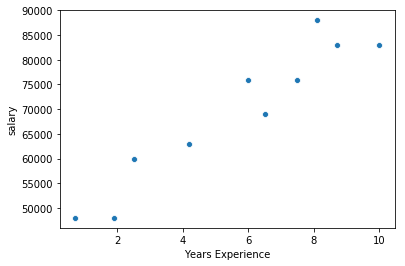

In [45]:
# この類のデータ（線形の相関が暗示されるようなデータ？）はプロットしたくなるもの、とのこと
# 詳細はここでは説明しませんが、例えばpandas形式に変換したデータをseabornに渡すと簡単に散布図（scatterplot）を描くことができます

import pandas as pd
import seaborn as sns

data = [list(x) for x in salaries_and_tenures]
df = pd.DataFrame(data, columns=["salary","Years Experience"])

ax = sns.scatterplot(x="Years Experience", y="salary", data=df)

In [48]:
# 勤続年数ごとの平均給与

# 年数をキーといsて給与額のリストを値とする辞書
salary_by_tenure = defaultdict(list)
for salary, tenure in salaries_and_tenures: 
    salary_by_tenure[tenure].append(salary)
    
# 年数をキーとして勤続年数ごとの給与返金を値とする辞書
average_salary_by_tenure = {
    tenure: sum(salaries) / len(salaries)
    for tenure, salaries in salary_by_tenure.items() }

average_salary_by_tenure

{8.7: 83000.0,
 8.1: 88000.0,
 0.7: 48000.0,
 6: 76000.0,
 6.5: 69000.0,
 7.5: 76000.0,
 2.5: 60000.0,
 10: 83000.0,
 1.9: 48000.0,
 4.2: 63000.0}

In [51]:
# 勤続年数をバケツ（=bucket, バケット、ある大きさを持った入れ物ぐらいの意味）でグループ化する関数

def tenure_bucket(tenure): 
    if tenure < 2:
        return "less than two"
    elif tenure < 5:
        return "between two and five"
    else:
        return "more than five"

In [56]:
# 勤続年数のバケツごとに給与額をまとめる

salary_by_tenure_bucket  =defaultdict(list)

for salary, tenure in salaries_and_tenures:
    bucket = tenure_bucket(tenure) 
    salary_by_tenure_bucket[bucket].append(salary)
    
# バケツごと給与平均を求める
average_salary_by_bucket = {
    tenure_bucket: sum(salaries) / len(salaries)
    for tenure_bucket, salaries in salary_by_tenure_bucket.items()
}

average_salary_by_bucket

{'more than five': 79166.66666666667,
 'less than two': 48000.0,
 'between two and five': 61500.0}

 ## 1.3.4 有料アカウント

In [ ]:
# 利用年数から有料と無料を予測する適当な関数

def predict_paid_or_unpaid(years_experience): 
    if years_experience < 3.0:
        return "paid"
    elif years_experience < 8.5:
        return "unpaid"
    else:
        return "paid"

## 1.3.5 興味に関するあれこれ

In [60]:
# 1.3.2 の各ユーザの興味(user_id, 興味のある分野)のデータ"interests"を利用して、出現する単語をカウントし、最も人気のある興味を見つける

words_and_counts = Counter(word
    for user, interest in interests
    for word in interest.lower().split())

for word, count in words_and_counts.most_common(): 
    if count > 1:
        print(word, count)

big 3
data 3
java 3
python 3
learning 3
hadoop 2
hbase 2
cassandra 2
scikit-learn 2
r 2
statistics 2
regression 2
probability 2
machine 2
neural 2
networks 2
